In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from src.data.scrape_reports import scrape_pdf_reports, scrape_urls_responsibilityreports_website

In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## 1. Scrape all CSR URLs from *responsibilityreports.com*

In [4]:
# Scrape URLs
df_responsibilityreports = scrape_urls_responsibilityreports_website()
df_responsibilityreports

,Link,Company_Name,Ticker,Exchange,Financial_Period_Absolute,CSR_URL
0,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2021,https://www.responsibilityreports.com/Click/1194
1,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2021,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/3/LSE_III_2020.pdf
...,...,...,...,...,...,...
8755,https://www.responsibilityreports.com/Company/orsted,Ørsted,DOGEF,OTC,2018,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/o/OTC_DOGEF_2018.pdf
8756,https://www.responsibilityreports.com/Company/orsted,Ørsted,DOGEF,OTC,2017,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/o/OTC_DOGEF_2017.pdf


In [8]:
# Have a look at the exchanges
df_responsibilityreports['Exchange'].unique()

array(['LSE', 'NYSE', 'NASDAQ', 'ASX', '', 'OTC', 'TSX', 'AMEX',
       'NYSETSX', 'OTCLSE'], dtype=object)

In [13]:
# Only keep companies listed at exchanges in the US, Canada, UK and Australia to prevent non-english CSRs
df_responsibilityreports['Exchange'] = np.where(df_responsibilityreports['Exchange'] == 'AMEX', 'NYSE', df_responsibilityreports['Exchange'])
df_responsibilityreports['Exchange'] = np.where(df_responsibilityreports['Exchange'] == 'NYSETSX', 'NYSE', df_responsibilityreports['Exchange'])
df_responsibilityreports['Exchange'] = np.where(df_responsibilityreports['Exchange'] == 'OTCLSE', 'LSE', df_responsibilityreports['Exchange'])
df_responsibilityreports = df_responsibilityreports[(df_responsibilityreports['Exchange'] != '') & (df_responsibilityreports['Exchange'] != 'OTC')]

# Only keep rows for which a URL could be scraped and remove duplicates
df_responsibilityreports = df_responsibilityreports[df_responsibilityreports['CSR_URL'] != '']
df_responsibilityreports.drop_duplicates(subset=['CSR_URL'], keep='first', inplace=True)
df_responsibilityreports.drop_duplicates(subset=['Ticker', 'Financial_Period_Absolute'], keep='first', inplace=True)

# Reset index
df_responsibilityreports = df_responsibilityreports.reset_index(drop=True)
df_responsibilityreports

,Link,Company_Name,Ticker,Exchange,Financial_Period_Absolute,CSR_URL
0,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2021,https://www.responsibilityreports.com/Click/1194
1,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2019,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/3/LSE_III_2019.pdf
...,...,...,...,...,...,...
5555,https://www.responsibilityreports.com/Company/zimmer-holdings-inc,Zimmer Holdings Inc.,ZMH,NYSE,2016,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZMH_2016.pdf
5556,https://www.responsibilityreports.com/Company/zimmer-holdings-inc,Zimmer Holdings Inc.,ZMH,NYSE,2015,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZMH_2015.pdf


In [15]:
# Store to Excel
df_responsibilityreports.to_excel('data/raw/responsibilityreports_urls.xlsx', index=False)

## 2. Add Reuters Identifiers and merge ESG metrics from Refinitiv

In [18]:
# Load df to map tickers to identifiers (manually obtained using Refinitiv Eikon Terminal)
ticker_identifier_mapping = pd.read_excel('data/raw/ticker_identifier_mapping.xlsx')
ticker_identifier_mapping

,Company_Name,Ticker,Exchange,Identifier
0,3i Group plc,III,LSE,III.L
1,3M Corporation,MMM,NYSE,MMM.N
...,...,...,...,...
1335,Zimmer Biomet,ZBH,NYSE,ZBH.N
1336,Zimmer Holdings Inc.,ZMH,NYSE,ZMH.N


In [19]:
# Add Identifiers
df_responsibilityreports_identifiers = df_responsibilityreports.merge(ticker_identifier_mapping[['Ticker', 'Exchange', 'Identifier']], how='left', on=['Ticker', 'Exchange'])
df_responsibilityreports_identifiers

,Link,Company_Name,Ticker,Exchange,Financial_Period_Absolute,CSR_URL,Identifier
0,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2021,https://www.responsibilityreports.com/Click/1194,III.L
1,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2019,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/3/LSE_III_2019.pdf,III.L
...,...,...,...,...,...,...,...
5555,https://www.responsibilityreports.com/Company/zimmer-holdings-inc,Zimmer Holdings Inc.,ZMH,NYSE,2016,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZMH_2016.pdf,ZMH.N
5556,https://www.responsibilityreports.com/Company/zimmer-holdings-inc,Zimmer Holdings Inc.,ZMH,NYSE,2015,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZMH_2015.pdf,ZMH.N


In [22]:
# Only keep rows with Identifier
df_responsibilityreports_identifiers = df_responsibilityreports_identifiers[df_responsibilityreports_identifiers['Identifier'].notna()]
df_responsibilityreports_identifiers

,Link,Company_Name,Ticker,Exchange,Financial_Period_Absolute,CSR_URL,Identifier
0,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2021,https://www.responsibilityreports.com/Click/1194,III.L
1,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2019,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/3/LSE_III_2019.pdf,III.L
...,...,...,...,...,...,...,...
5555,https://www.responsibilityreports.com/Company/zimmer-holdings-inc,Zimmer Holdings Inc.,ZMH,NYSE,2016,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZMH_2016.pdf,ZMH.N
5556,https://www.responsibilityreports.com/Company/zimmer-holdings-inc,Zimmer Holdings Inc.,ZMH,NYSE,2015,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZMH_2015.pdf,ZMH.N


In [38]:
# Load df with ESG metrics from Refinitiv (manually obtained using Refinitiv Eikon Terminal)
df_responsibilityreports_metrics = pd.read_excel('data/raw/refinitiv_data_responsibilityreports.xlsx')
df_responsibilityreports_metrics

,Identifier,Company Name,ISIN,Ticker,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,Product Access Low Price,Community Lending and Investments Score,Obesity Risk,Policy Employee Health & Safety,Policy Supply Chain Health & Safety,Health & Safety Training,Supply Chain Health & Safety Training,HIV-AIDS Program,Policy Skills Training,Policy Career Development,Employees With Disabilities Score,Training Costs Per Employee Score,Policy Diversity and Opportunity,Targets Diversity and Opportunity,Human Rights Policy,Policy Water Efficiency,Toxic Chemicals Reduction,Targets Water Efficiency,Water Use To Revenues USD Score,Waste Reduction Initiatives,Waste Recycling Ratio,Biodiversity Impact Reduction,Water Technologies,Renewable Energy Use,Policy Energy Efficiency,Renewable/Clean Energy Products,Product Environmental Responsible Use,Policy Child Labor,Policy Forced Labor,Policy Human Rights,Environmental Innovation Score,Product Sales at Discount to Emerging Markets,Environmental Materials Sourcing,Policy Sustainable Packaging,Policy Environmental Supply Chain,Take-back and Recycling Initiatives,CSR Sustainability Reporting,Resource Use Score,Emissions Score,Climate Change Commercial Risks Opportunities,Environmental Project Financing,Fundamental Human Rights ILO UN,Policy Bribery and Corruption
0,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,FY2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.000000,True,False,True,True,True,True,63.114754,True,35.499,True,False,True,True,False,True,True,True,True,49.180328,False,True,True,True,True,True,95.578231,97.482014,True,False,True,True
1,AA.N,Alcoa Corp,US0138721065,AA,United States of America,FY2020,FY0,https://www.alcoa.com/sustainability/en/pdf/2020-Sustainability-Report.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,77.118644,True,True,True,True,False,True,2.709360,True,0.000,True,False,True,True,False,True,True,True,True,50.000000,False,False,False,True,True,True,87.681159,89.943343,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15144,XLNX.OQ,Xilinx Inc,US9839191015,XLNX,United States of America,FY2002,FY-18,NaN,False,0.0,False,False,False,False,False,False,False,False,0.0,0.000000,False,False,False,False,False,False,0.000000,False,0.000,False,False,False,False,False,False,False,False,False,0.000000,False,False,False,False,False,False,0.000000,0.000000,False,False,False,False
15145,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,FY2002,FY-18,NaN,False,0.0,False,False,False,False,False,False,True,False,0.0,0.000000,False,False,True,False,False,False,0.000000,False,0.000,False,False,False,False,False,False,False,False,False,0.000000,False,False,False,False,False,False,0.000000,0.000000,False,False,False,False


In [39]:
# Format column 'Financial Period Absolute'
df_responsibilityreports_metrics['Financial Period Absolute'] = df_responsibilityreports_metrics['Financial Period Absolute'].str.replace('FY', '')
df_responsibilityreports_metrics['Financial Period Absolute'] = df_responsibilityreports_metrics['Financial Period Absolute'].astype(int)
df_responsibilityreports_metrics

,Identifier,Company Name,ISIN,Ticker,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,Product Access Low Price,Community Lending and Investments Score,Obesity Risk,Policy Employee Health & Safety,Policy Supply Chain Health & Safety,Health & Safety Training,Supply Chain Health & Safety Training,HIV-AIDS Program,Policy Skills Training,Policy Career Development,Employees With Disabilities Score,Training Costs Per Employee Score,Policy Diversity and Opportunity,Targets Diversity and Opportunity,Human Rights Policy,Policy Water Efficiency,Toxic Chemicals Reduction,Targets Water Efficiency,Water Use To Revenues USD Score,Waste Reduction Initiatives,Waste Recycling Ratio,Biodiversity Impact Reduction,Water Technologies,Renewable Energy Use,Policy Energy Efficiency,Renewable/Clean Energy Products,Product Environmental Responsible Use,Policy Child Labor,Policy Forced Labor,Policy Human Rights,Environmental Innovation Score,Product Sales at Discount to Emerging Markets,Environmental Materials Sourcing,Policy Sustainable Packaging,Policy Environmental Supply Chain,Take-back and Recycling Initiatives,CSR Sustainability Reporting,Resource Use Score,Emissions Score,Climate Change Commercial Risks Opportunities,Environmental Project Financing,Fundamental Human Rights ILO UN,Policy Bribery and Corruption
0,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.000000,True,False,True,True,True,True,63.114754,True,35.499,True,False,True,True,False,True,True,True,True,49.180328,False,True,True,True,True,True,95.578231,97.482014,True,False,True,True
1,AA.N,Alcoa Corp,US0138721065,AA,United States of America,2020,FY0,https://www.alcoa.com/sustainability/en/pdf/2020-Sustainability-Report.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,77.118644,True,True,True,True,False,True,2.709360,True,0.000,True,False,True,True,False,True,True,True,True,50.000000,False,False,False,True,True,True,87.681159,89.943343,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15144,XLNX.OQ,Xilinx Inc,US9839191015,XLNX,United States of America,2002,FY-18,NaN,False,0.0,False,False,False,False,False,False,False,False,0.0,0.000000,False,False,False,False,False,False,0.000000,False,0.000,False,False,False,False,False,False,False,False,False,0.000000,False,False,False,False,False,False,0.000000,0.000000,False,False,False,False
15145,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2002,FY-18,NaN,False,0.0,False,False,False,False,False,False,True,False,0.0,0.000000,False,False,True,False,False,False,0.000000,False,0.000,False,False,False,False,False,False,False,False,False,0.000000,False,False,False,False,False,False,0.000000,0.000000,False,False,False,False


In [40]:
# Merge metrics to reports
df_responsibilityreports_merged = df_responsibilityreports_identifiers.merge(df_responsibilityreports_metrics, how="left", left_on=['Identifier', 'Financial_Period_Absolute'], right_on=['Identifier', 'Financial Period Absolute'])
df_responsibilityreports_merged

,Link,Company_Name,Ticker_x,Exchange,Financial_Period_Absolute,CSR_URL,Identifier,Company Name,ISIN,Ticker_y,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,Product Access Low Price,Community Lending and Investments Score,Obesity Risk,Policy Employee Health & Safety,Policy Supply Chain Health & Safety,Health & Safety Training,Supply Chain Health & Safety Training,HIV-AIDS Program,Policy Skills Training,Policy Career Development,Employees With Disabilities Score,Training Costs Per Employee Score,Policy Diversity and Opportunity,Targets Diversity and Opportunity,Human Rights Policy,Policy Water Efficiency,Toxic Chemicals Reduction,Targets Water Efficiency,Water Use To Revenues USD Score,Waste Reduction Initiatives,Waste Recycling Ratio,Biodiversity Impact Reduction,Water Technologies,Renewable Energy Use,Policy Energy Efficiency,Renewable/Clean Energy Products,Product Environmental Responsible Use,Policy Child Labor,Policy Forced Labor,Policy Human Rights,Environmental Innovation Score,Product Sales at Discount to Emerging Markets,Environmental Materials Sourcing,Policy Sustainable Packaging,Policy Environmental Supply Chain,Take-back and Recycling Initiatives,CSR Sustainability Reporting,Resource Use Score,Emissions Score,Climate Change Commercial Risks Opportunities,Environmental Project Financing,Fundamental Human Rights ILO UN,Policy Bribery and Corruption
0,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2021,https://www.responsibilityreports.com/Click/1194,III.L,3i Group PLC,GB00B1YW4409,III,United Kingdom,2021.0,FY0,https://www.3i.com/media/5215/3i_sr21_interactive.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,False,False,False,0.0,True,47.797,False,False,True,True,True,True,True,True,True,85.256410,False,False,False,True,False,True,75.853659,91.586538,True,True,True,True
1,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2019,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/3/LSE_III_2019.pdf,III.L,3i Group PLC,GB00B1YW4409,III,United Kingdom,2019.0,FY-2,https://www.3i.com/media/4107/3i-sustainability-report-2019.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,False,False,False,0.0,True,57.725,False,False,True,True,True,True,True,True,True,87.410072,False,False,False,True,False,True,79.508197,85.904255,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5544,https://www.responsibilityreports.com/Company/zimmer-holdings-inc,Zimmer Holdings Inc.,ZMH,NYSE,2016,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZMH_2016.pdf,ZMH.N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5545,https://www.responsibilityreports.com/Company/zimmer-holdings-inc,Zimmer Holdings Inc.,ZMH,NYSE,2015,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZMH_2015.pdf,ZMH.N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Only keep rows for which merging worked
df_responsibilityreports_merged_clean = df_responsibilityreports_merged[(df_responsibilityreports_merged['Product Access Low Price'].notna())]
df_responsibilityreports_merged_clean

,Link,Company_Name,Ticker_x,Exchange,Financial_Period_Absolute,CSR_URL,Identifier,Company Name,ISIN,Ticker_y,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,Product Access Low Price,Community Lending and Investments Score,Obesity Risk,Policy Employee Health & Safety,Policy Supply Chain Health & Safety,Health & Safety Training,Supply Chain Health & Safety Training,HIV-AIDS Program,Policy Skills Training,Policy Career Development,Employees With Disabilities Score,Training Costs Per Employee Score,Policy Diversity and Opportunity,Targets Diversity and Opportunity,Human Rights Policy,Policy Water Efficiency,Toxic Chemicals Reduction,Targets Water Efficiency,Water Use To Revenues USD Score,Waste Reduction Initiatives,Waste Recycling Ratio,Biodiversity Impact Reduction,Water Technologies,Renewable Energy Use,Policy Energy Efficiency,Renewable/Clean Energy Products,Product Environmental Responsible Use,Policy Child Labor,Policy Forced Labor,Policy Human Rights,Environmental Innovation Score,Product Sales at Discount to Emerging Markets,Environmental Materials Sourcing,Policy Sustainable Packaging,Policy Environmental Supply Chain,Take-back and Recycling Initiatives,CSR Sustainability Reporting,Resource Use Score,Emissions Score,Climate Change Commercial Risks Opportunities,Environmental Project Financing,Fundamental Human Rights ILO UN,Policy Bribery and Corruption
0,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2021,https://www.responsibilityreports.com/Click/1194,III.L,3i Group PLC,GB00B1YW4409,III,United Kingdom,2021.0,FY0,https://www.3i.com/media/5215/3i_sr21_interactive.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,False,False,False,0.0,True,47.797,False,False,True,True,True,True,True,True,True,85.256410,False,False,False,True,False,True,75.853659,91.586538,True,True,True,True
1,https://www.responsibilityreports.com/Company/3i-group-plc,3i Group plc,III,LSE,2019,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/3/LSE_III_2019.pdf,III.L,3i Group PLC,GB00B1YW4409,III,United Kingdom,2019.0,FY-2,https://www.3i.com/media/4107/3i-sustainability-report-2019.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,False,False,False,0.0,True,57.725,False,False,True,True,True,True,True,True,True,87.410072,False,False,False,True,False,True,79.508197,85.904255,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,https://www.responsibilityreports.com/Company/zimmer-biomet,Zimmer Biomet,ZBH,NYSE,2016,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016.0,FY-4,NaN,False,0.0,False,True,True,True,False,False,True,True,0.0,0.0,True,False,True,True,False,False,0.0,True,0.000,False,False,True,True,False,False,True,False,False,0.000000,False,False,False,False,False,False,15.909091,9.615385,False,False,False,True
5540,https://www.responsibilityreports.com/Company/zimmer-biomet,Zimmer Biomet,ZBH,NYSE,2015,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015.0,FY-5,NaN,False,0.0,False,True,True,True,False,False,True,True,0.0,0.0,True,False,False,True,True,False,0.0,True,0.000,False,False,True,True,False,True,False,False,False,50.000000,False,True,True,True,False,False,60.169492,54.081633,False,False,False,True


In [42]:
# Drop and rename columns
df_responsibilityreports_merged_clean['CSR URL'] = df_responsibilityreports_merged_clean['CSR_URL']
df_responsibilityreports_merged_clean['Financial Period Absolute'] = df_responsibilityreports_merged_clean['Financial_Period_Absolute']
df_responsibilityreports_merged_clean.rename(columns={'Ticker_y': 'Ticker'}, inplace=True)
df_responsibilityreports_merged_clean.drop(['Link', 'Company_Name', 'Ticker_x', 'Exchange', 'Financial_Period_Absolute', 'CSR_URL'], axis=1, inplace=True)
df_responsibilityreports_merged_clean

,Identifier,Company Name,ISIN,Ticker,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,Product Access Low Price,Community Lending and Investments Score,Obesity Risk,Policy Employee Health & Safety,Policy Supply Chain Health & Safety,Health & Safety Training,Supply Chain Health & Safety Training,HIV-AIDS Program,Policy Skills Training,Policy Career Development,Employees With Disabilities Score,Training Costs Per Employee Score,Policy Diversity and Opportunity,Targets Diversity and Opportunity,Human Rights Policy,Policy Water Efficiency,Toxic Chemicals Reduction,Targets Water Efficiency,Water Use To Revenues USD Score,Waste Reduction Initiatives,Waste Recycling Ratio,Biodiversity Impact Reduction,Water Technologies,Renewable Energy Use,Policy Energy Efficiency,Renewable/Clean Energy Products,Product Environmental Responsible Use,Policy Child Labor,Policy Forced Labor,Policy Human Rights,Environmental Innovation Score,Product Sales at Discount to Emerging Markets,Environmental Materials Sourcing,Policy Sustainable Packaging,Policy Environmental Supply Chain,Take-back and Recycling Initiatives,CSR Sustainability Reporting,Resource Use Score,Emissions Score,Climate Change Commercial Risks Opportunities,Environmental Project Financing,Fundamental Human Rights ILO UN,Policy Bribery and Corruption
0,III.L,3i Group PLC,GB00B1YW4409,III,United Kingdom,2021,FY0,https://www.responsibilityreports.com/Click/1194,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,False,False,False,0.0,True,47.797,False,False,True,True,True,True,True,True,True,85.256410,False,False,False,True,False,True,75.853659,91.586538,True,True,True,True
1,III.L,3i Group PLC,GB00B1YW4409,III,United Kingdom,2019,FY-2,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/3/LSE_III_2019.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,False,False,False,0.0,True,57.725,False,False,True,True,True,True,True,True,True,87.410072,False,False,False,True,False,True,79.508197,85.904255,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,0.0,False,True,True,True,False,False,True,True,0.0,0.0,True,False,True,True,False,False,0.0,True,0.000,False,False,True,True,False,False,True,False,False,0.000000,False,False,False,False,False,False,15.909091,9.615385,False,False,False,True
5540,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,0.0,False,True,True,True,False,False,True,True,0.0,0.0,True,False,False,True,True,False,0.0,True,0.000,False,False,True,True,False,True,False,False,False,50.000000,False,True,True,True,False,False,60.169492,54.081633,False,False,False,True


## 3. Combine with dataset of reports obtained from refinitiv

In [43]:
# Load data
df_refinitiv = pd.read_excel('data/raw/refinitiv_data_countries.xlsx')
df_refinitiv

,Identifier,Company Name,ISIN,Ticker,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,Product Access Low Price,Community Lending and Investments Score,Obesity Risk,Policy Employee Health & Safety,Policy Supply Chain Health & Safety,Health & Safety Training,Supply Chain Health & Safety Training,HIV-AIDS Program,Policy Skills Training,Policy Career Development,Employees With Disabilities Score,Training Costs Per Employee Score,Policy Diversity and Opportunity,Targets Diversity and Opportunity,Human Rights Policy,Policy Water Efficiency,Toxic Chemicals Reduction,Targets Water Efficiency,Water Use To Revenues USD Score,Waste Reduction Initiatives,Waste Recycling Ratio,Biodiversity Impact Reduction,Water Technologies,Renewable Energy Use,Policy Energy Efficiency,Renewable/Clean Energy Products,Product Environmental Responsible Use,Policy Child Labor,Policy Forced Labor,Policy Human Rights,Environmental Innovation Score,Product Sales at Discount to Emerging Markets,Environmental Materials Sourcing,Policy Sustainable Packaging,Policy Environmental Supply Chain,Take-back and Recycling Initiatives,CSR Sustainability Reporting,Resource Use Score,Emissions Score,Climate Change Commercial Risks Opportunities,Environmental Project Financing,Fundamental Human Rights ILO UN,Policy Bribery and Corruption
0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,FY2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.000000,True,False,True,True,False,False,0.000000,True,0.000,False,False,True,True,False,False,True,True,True,0.0,False,False,False,True,False,True,21.025641,78.436019,True,False,True,True
1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,FY2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.000000,True,False,True,True,True,True,63.114754,True,35.499,True,False,True,True,False,True,True,True,True,50.0,False,True,True,True,True,True,95.608108,97.463768,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11381,YRI.TO,Yamana Gold Inc,CA98462Y1007,YRI,Canada,FY2010,FY-10,http://www.yamana.com/Theme/NewYamana/files/YAMANA%20CSR-E%2017-08-11b.pdf,False,0.0,False,True,False,True,False,True,True,True,0.0,21.794872,False,False,True,True,False,True,60.891089,True,28.500,True,False,True,True,False,False,False,False,False,0.0,False,False,False,True,False,True,97.668394,87.760417,True,False,False,True
11382,YUM.N,Yum! Brands Inc,US9884981013,YUM,United States of America,FY2010,FY-10,http://www.yum.com/responsibility/,False,0.0,False,True,True,True,False,True,True,True,0.0,0.000000,True,False,True,True,False,True,0.000000,True,0.000,False,False,True,True,False,False,False,False,False,0.0,False,True,True,True,False,True,91.911765,38.281250,False,False,False,True


In [44]:
# Format column
df_refinitiv['Financial Period Absolute'] = df_refinitiv['Financial Period Absolute'].str.replace('FY', '')
df_refinitiv['Financial Period Absolute'] = df_refinitiv['Financial Period Absolute'].astype(int)
df_refinitiv

,Identifier,Company Name,ISIN,Ticker,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,Product Access Low Price,Community Lending and Investments Score,Obesity Risk,Policy Employee Health & Safety,Policy Supply Chain Health & Safety,Health & Safety Training,Supply Chain Health & Safety Training,HIV-AIDS Program,Policy Skills Training,Policy Career Development,Employees With Disabilities Score,Training Costs Per Employee Score,Policy Diversity and Opportunity,Targets Diversity and Opportunity,Human Rights Policy,Policy Water Efficiency,Toxic Chemicals Reduction,Targets Water Efficiency,Water Use To Revenues USD Score,Waste Reduction Initiatives,Waste Recycling Ratio,Biodiversity Impact Reduction,Water Technologies,Renewable Energy Use,Policy Energy Efficiency,Renewable/Clean Energy Products,Product Environmental Responsible Use,Policy Child Labor,Policy Forced Labor,Policy Human Rights,Environmental Innovation Score,Product Sales at Discount to Emerging Markets,Environmental Materials Sourcing,Policy Sustainable Packaging,Policy Environmental Supply Chain,Take-back and Recycling Initiatives,CSR Sustainability Reporting,Resource Use Score,Emissions Score,Climate Change Commercial Risks Opportunities,Environmental Project Financing,Fundamental Human Rights ILO UN,Policy Bribery and Corruption
0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.000000,True,False,True,True,False,False,0.000000,True,0.000,False,False,True,True,False,False,True,True,True,0.0,False,False,False,True,False,True,21.025641,78.436019,True,False,True,True
1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.000000,True,False,True,True,True,True,63.114754,True,35.499,True,False,True,True,False,True,True,True,True,50.0,False,True,True,True,True,True,95.608108,97.463768,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11381,YRI.TO,Yamana Gold Inc,CA98462Y1007,YRI,Canada,2010,FY-10,http://www.yamana.com/Theme/NewYamana/files/YAMANA%20CSR-E%2017-08-11b.pdf,False,0.0,False,True,False,True,False,True,True,True,0.0,21.794872,False,False,True,True,False,True,60.891089,True,28.500,True,False,True,True,False,False,False,False,False,0.0,False,False,False,True,False,True,97.668394,87.760417,True,False,False,True
11382,YUM.N,Yum! Brands Inc,US9884981013,YUM,United States of America,2010,FY-10,http://www.yum.com/responsibility/,False,0.0,False,True,True,True,False,True,True,True,0.0,0.000000,True,False,True,True,False,True,0.000000,True,0.000,False,False,True,True,False,False,False,False,False,0.0,False,True,True,True,False,True,91.911765,38.281250,False,False,False,True


In [63]:
# Append dataframe
df = df_refinitiv.append(df_responsibilityreports_merged_clean)
df

,Identifier,Company Name,ISIN,Ticker,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,Product Access Low Price,Community Lending and Investments Score,Obesity Risk,Policy Employee Health & Safety,Policy Supply Chain Health & Safety,Health & Safety Training,Supply Chain Health & Safety Training,HIV-AIDS Program,Policy Skills Training,Policy Career Development,Employees With Disabilities Score,Training Costs Per Employee Score,Policy Diversity and Opportunity,Targets Diversity and Opportunity,Human Rights Policy,Policy Water Efficiency,Toxic Chemicals Reduction,Targets Water Efficiency,Water Use To Revenues USD Score,Waste Reduction Initiatives,Waste Recycling Ratio,Biodiversity Impact Reduction,Water Technologies,Renewable Energy Use,Policy Energy Efficiency,Renewable/Clean Energy Products,Product Environmental Responsible Use,Policy Child Labor,Policy Forced Labor,Policy Human Rights,Environmental Innovation Score,Product Sales at Discount to Emerging Markets,Environmental Materials Sourcing,Policy Sustainable Packaging,Policy Environmental Supply Chain,Take-back and Recycling Initiatives,CSR Sustainability Reporting,Resource Use Score,Emissions Score,Climate Change Commercial Risks Opportunities,Environmental Project Financing,Fundamental Human Rights ILO UN,Policy Bribery and Corruption
0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,True,False,False,0.000000,True,0.000,False,False,True,True,False,False,True,True,True,0.0,False,False,False,True,False,True,21.025641,78.436019,True,False,True,True
1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,True,True,True,63.114754,True,35.499,True,False,True,True,False,True,True,True,True,50.0,False,True,True,True,True,True,95.608108,97.463768,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,0.0,False,True,True,True,False,False,True,True,0.0,0.0,True,False,True,True,False,False,0.000000,True,0.000,False,False,True,True,False,False,True,False,False,0.0,False,False,False,False,False,False,15.909091,9.615385,False,False,False,True
5540,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,0.0,False,True,True,True,False,False,True,True,0.0,0.0,True,False,False,True,True,False,0.000000,True,0.000,False,False,True,True,False,True,False,False,False,50.0,False,True,True,True,False,False,60.169492,54.081633,False,False,False,True


In [64]:
# Remove duplicates and rows without URL
df['Financial Period Absolute'] = df['Financial Period Absolute'].astype(int)
df = df.drop_duplicates(['Identifier', 'Financial Period Absolute'], keep='last')
df = df[df['CSR URL'].notna()]

# Reset index
df = df.reset_index(drop=True)
df

,Identifier,Company Name,ISIN,Ticker,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,Product Access Low Price,Community Lending and Investments Score,Obesity Risk,Policy Employee Health & Safety,Policy Supply Chain Health & Safety,Health & Safety Training,Supply Chain Health & Safety Training,HIV-AIDS Program,Policy Skills Training,Policy Career Development,Employees With Disabilities Score,Training Costs Per Employee Score,Policy Diversity and Opportunity,Targets Diversity and Opportunity,Human Rights Policy,Policy Water Efficiency,Toxic Chemicals Reduction,Targets Water Efficiency,Water Use To Revenues USD Score,Waste Reduction Initiatives,Waste Recycling Ratio,Biodiversity Impact Reduction,Water Technologies,Renewable Energy Use,Policy Energy Efficiency,Renewable/Clean Energy Products,Product Environmental Responsible Use,Policy Child Labor,Policy Forced Labor,Policy Human Rights,Environmental Innovation Score,Product Sales at Discount to Emerging Markets,Environmental Materials Sourcing,Policy Sustainable Packaging,Policy Environmental Supply Chain,Take-back and Recycling Initiatives,CSR Sustainability Reporting,Resource Use Score,Emissions Score,Climate Change Commercial Risks Opportunities,Environmental Project Financing,Fundamental Human Rights ILO UN,Policy Bribery and Corruption
0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,True,False,False,0.000000,True,0.000,False,False,True,True,False,False,True,True,True,0.0,False,False,False,True,False,True,21.025641,78.436019,True,False,True,True
1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,0.0,False,True,False,True,False,False,True,True,0.0,0.0,True,False,True,True,True,True,63.114754,True,35.499,True,False,True,True,False,True,True,True,True,50.0,False,True,True,True,True,True,95.608108,97.463768,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,0.0,False,True,True,True,False,False,True,True,0.0,0.0,True,False,True,True,False,False,0.000000,True,0.000,False,False,True,True,False,False,True,False,False,0.0,False,False,False,False,False,False,15.909091,9.615385,False,False,False,True
12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,0.0,False,True,True,True,False,False,True,True,0.0,0.0,True,False,False,True,True,False,0.000000,True,0.000,False,False,True,True,False,True,False,False,False,50.0,False,True,True,True,False,False,60.169492,54.081633,False,False,False,True


In [65]:
# Check datatypes: 43 ESG metric columns, from which 8 contain float values and 35 contain bool values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12678 entries, 0 to 12677
Data columns (total 51 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Identifier                                     12678 non-null  object 
 1   Company Name                                   12678 non-null  object 
 2   ISIN                                           12677 non-null  object 
 3   Ticker                                         12567 non-null  object 
 4   Country of Exchange                            12678 non-null  object 
 5   Financial Period Absolute                      12678 non-null  int32  
 6   Financial Period Relative                      12678 non-null  object 
 7   CSR URL                                        12678 non-null  object 
 8   Product Access Low Price                       12678 non-null  object 
 9   Community Lending and Investments Score        126

In [66]:
# Check for missing values
for column in df.columns:
    if sum(df[column].isna()) > 0:
        print(column + ' has ' + str(sum(df[column].isna())) + ' missing values' )
# Missing ISINs and Tickers are no problem

ISIN has 1 missing values
Ticker has 111 missing values


## 4. Transform numeric columns to bool

In [67]:
# Check distribution of numeric columns: All columns contain scores from 0 to 100
df.describe()

,Financial Period Absolute,Community Lending and Investments Score,Employees With Disabilities Score,Training Costs Per Employee Score,Water Use To Revenues USD Score,Waste Recycling Ratio,Environmental Innovation Score,Resource Use Score,Emissions Score
count,12678.000000,12678.000000,12678.000000,12678.000000,12678.000000,12678.000000,12678.000000,12678.000000,12678.000000
mean,2015.931535,0.822594,2.871197,5.975523,28.113093,22.553754,31.127679,58.309213,58.232440
...,...,...,...,...,...,...,...,...,...
75%,2019.000000,0.000000,0.000000,0.000000,55.882353,49.491000,56.534091,82.097723,80.210572
max,2021.000000,91.666667,99.615385,99.367089,99.768519,100.000000,99.848485,99.883178,99.803150


In [68]:
# Assign TRUE if value > mean and FALSE if value <= mean
for column in ['Community Lending and Investments Score', 'Employees With Disabilities Score', 'Training Costs Per Employee Score', 'Water Use To Revenues USD Score', 'Waste Recycling Ratio', 'Environmental Innovation Score', 'Resource Use Score', 'Emissions Score']:
    df[column] = df[column] > df[column].mean()

In [69]:
# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12678 entries, 0 to 12677
Data columns (total 51 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Identifier                                     12678 non-null  object
 1   Company Name                                   12678 non-null  object
 2   ISIN                                           12677 non-null  object
 3   Ticker                                         12567 non-null  object
 4   Country of Exchange                            12678 non-null  object
 5   Financial Period Absolute                      12678 non-null  int32 
 6   Financial Period Relative                      12678 non-null  object
 7   CSR URL                                        12678 non-null  object
 8   Product Access Low Price                       12678 non-null  object
 9   Community Lending and Investments Score        12678 non-null

## 5. Explore data

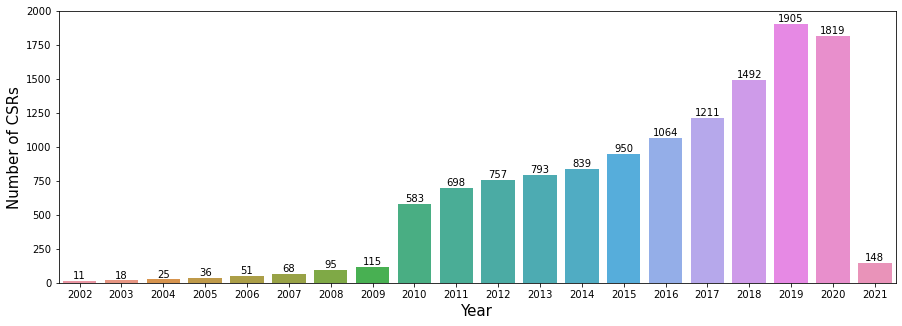

In [71]:
# Number of CSRs per year    
xs = []
ys = []
for year in np.sort(df['Financial Period Absolute'].unique()):
    xs.append(year)
    ys.append(sum(df['Financial Period Absolute'].astype(str) == str(year)))

plt.figure(figsize=(15,5))
ax = sns.barplot(x=xs, y=ys)
ax.bar_label(ax.containers[0])
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of CSRs", fontsize=15)
plt.show()

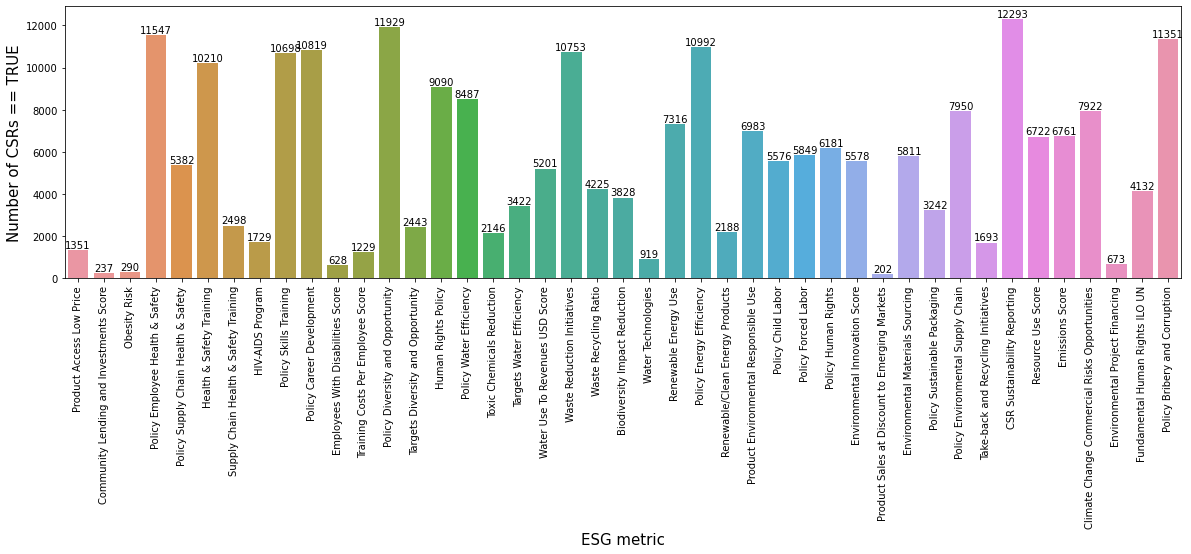

In [72]:
# Number of TRUE per ESG metric
xs = []
ys = []
for column in df.columns[8:]:
    xs.append(column)
    ys.append(sum(df[column] == True))

plt.figure(figsize=(20,5))
ax = sns.barplot(x=xs, y=ys)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.xlabel("ESG metric", fontsize=15)
plt.ylabel("Number of CSRs == TRUE", fontsize=15)
plt.show()  

## 6. Map ESG metrics to SDGs
From NLP for SDGs paper: A company is designated as aligned with the respective SDG, depending on its score on the ESG metrics mapped to the SDG. If only one or two ESG metrics are mapped to the SDG, alignment requires a score on at least one, whereas if more than two metrics are mapped to the SDG, alignment requires a score for at least two.

For mapping table, see paper.

In [73]:
# Transform True/False to 1/0
for column in df.columns[8:]:
    df[column] = df[column].astype(int)

In [74]:
# Create one column per SDG of type bool
df['SDG_1'] = (df['Product Access Low Price'] + df['Community Lending and Investments Score']) > 0
df['SDG_2'] = (df['Obesity Risk'] == True)
df['SDG_3'] = (df['Policy Employee Health & Safety'] + df['Policy Supply Chain Health & Safety'] + df['Health & Safety Training'] + df['Supply Chain Health & Safety Training'] + df['HIV-AIDS Program']) > 1
df['SDG_4'] = (df['Policy Skills Training'] + df['Policy Career Development'] + df['Employees With Disabilities Score'] + df['Training Costs Per Employee Score']) > 1
df['SDG_5'] = (df['Policy Diversity and Opportunity'] + df['Targets Diversity and Opportunity'] + df['Human Rights Policy']) > 1
df['SDG_6'] = (df['Policy Water Efficiency'] + df['Toxic Chemicals Reduction'] + df['Targets Water Efficiency'] + df['Water Use To Revenues USD Score'] + df['Waste Reduction Initiatives'] + df['Waste Recycling Ratio'] + df['Biodiversity Impact Reduction'] + df['Water Technologies']) > 1
df['SDG_7'] = (df['Renewable Energy Use'] + df['Policy Energy Efficiency'] + df['Renewable/Clean Energy Products'] + df['Product Environmental Responsible Use']) > 1
df['SDG_8'] = (df['Human Rights Policy'] + df['Policy Child Labor'] + df['Policy Forced Labor'] + df['Employees With Disabilities Score'] + df['Policy Human Rights']) > 1
df['SDG_9'] = (df['Environmental Innovation Score'] + df['Community Lending and Investments Score'] + df['Product Sales at Discount to Emerging Markets']) > 1
df['SDG_10'] = np.nan
df['SDG_11'] = (df['Product Access Low Price'] == True)
# Removed 'CSR Sustainability Reporting'
df['SDG_12'] = (df['Environmental Materials Sourcing'] + df['Policy Water Efficiency'] + df['Policy Energy Efficiency'] + df['Policy Sustainable Packaging'] + df['Policy Environmental Supply Chain'] + df['Take-back and Recycling Initiatives'] + df['Waste Recycling Ratio'] + df['Resource Use Score'] + df['Emissions Score']) > 1
df['SDG_13'] = (df['Climate Change Commercial Risks Opportunities'] == True)
df['SDG_14'] = np.nan
df['SDG_15'] = (df['Biodiversity Impact Reduction'] + df['Environmental Project Financing']) > 0
df['SDG_16'] = (df['Human Rights Policy'] + df['Policy Child Labor'] + df['Fundamental Human Rights ILO UN'] + df['Policy Bribery and Corruption']) > 1
df['SDG_17'] = (df['Product Access Low Price'] == True)

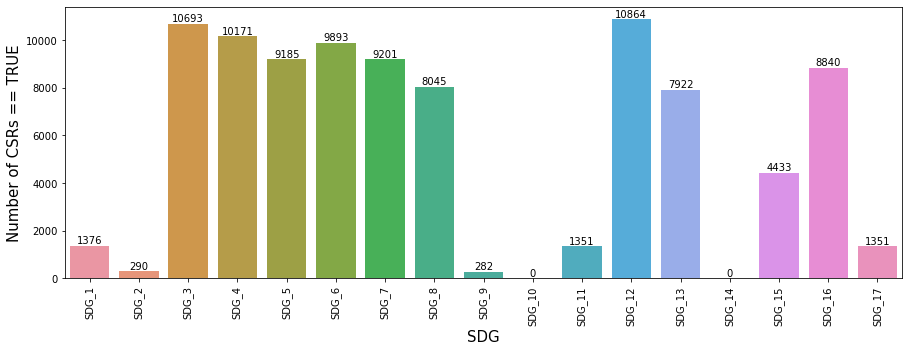

In [75]:
# Number of TRUE per SDG
xs = []
ys = []
for column in df.columns[51:]:
    xs.append(column)
    ys.append(sum(df[column] == True))

plt.figure(figsize=(15,5))
ax = sns.barplot(x=xs, y=ys)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.xlabel("SDG", fontsize=15)
plt.ylabel("Number of CSRs == TRUE", fontsize=15)
plt.show()  

## 7. Create new df and store reults in *reports_labeled*

In [76]:
# Select relevant columns
df_new = df[df.columns[:8].append(df.columns[51:])]
df_new

,Identifier,Company Name,ISIN,Ticker,Country of Exchange,Financial Period Absolute,Financial Period Relative,CSR URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False
1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False
12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False


In [77]:
# Rename columns (replace spaces by underscore)
columns_new = []
for column in df_new.columns:
    columns_new.append(column.replace(' ', '_'))
df_new.columns = columns_new
df_new

,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False
1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False
12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False


In [78]:
# Reset index
df_new = df_new.reset_index(drop=True)
df_new

,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False
1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False
12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False


In [79]:
# Store as Excel file
df_new.to_excel('data/interim/reports_labeled.xlsx', index=False)

## 8. Scrape reports

In [5]:
# Insert ID
df_new.insert(loc=0, column='ID', value=df_new.index)
df_new

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12676,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False
12677,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False


In [6]:
# Create new column to track scraping progress
df_new['CSR_Filename'] = ''

# Specify path to store the reports 
path_output = 'data/pdf_reports/

In [7]:
# Scrape reports
scrape_pdf_reports(df_new, path_output)
df_new

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12676,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf
12677,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf


In [8]:
# Store updated df to Excel
df_new.to_excel('data/interim/reports_labeled.xlsx', index=False)

In [32]:
# Only keep rows for which a report was scraped
df_new_clean = df_new[df_new['CSR_Filename'] != 'Error']
df_new_clean

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12646,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf
12647,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf


In [33]:
# Store to Excel
df_new_clean.to_excel('data/interim/reports_labeled_clean.xlsx', index=False)

## 9. Explore dataset

In [38]:
df_new_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8156 entries, 0 to 8155
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         8156 non-null   int64  
 1   Identifier                 8156 non-null   object 
 2   Company_Name               8156 non-null   object 
 3   ISIN                       8156 non-null   object 
 4   Ticker                     8046 non-null   object 
 5   Country_of_Exchange        8156 non-null   object 
 6   Financial_Period_Absolute  8156 non-null   int64  
 7   Financial_Period_Relative  8156 non-null   object 
 8   CSR_URL                    8156 non-null   object 
 9   SDG_1                      8156 non-null   bool   
 10  SDG_2                      8156 non-null   bool   
 11  SDG_3                      8156 non-null   bool   
 12  SDG_4                      8156 non-null   bool   
 13  SDG_5                      8156 non-null   bool 

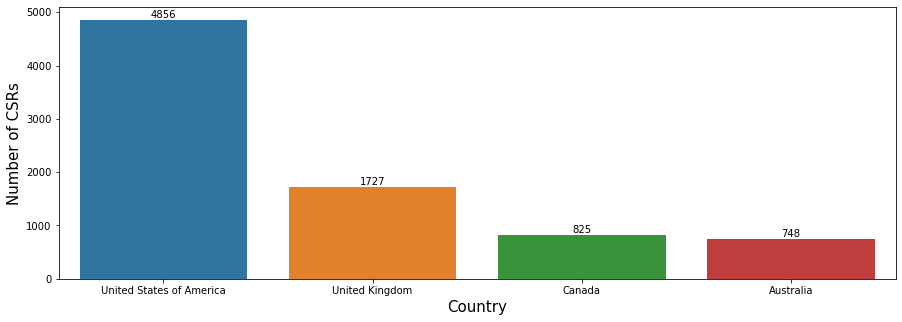

In [39]:
# Number of CSRs per country
xs = []
ys = []
for country in df_new_clean['Country_of_Exchange'].unique():
    xs.append(country)
    ys.append(sum(df_new_clean['Country_of_Exchange'] == country))

plt.figure(figsize=(15,5))
ax = sns.barplot(x=xs, y=ys, order = df_new_clean['Country_of_Exchange'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.xlabel("Country", fontsize=15)
plt.ylabel("Number of CSRs", fontsize=15)
plt.show()

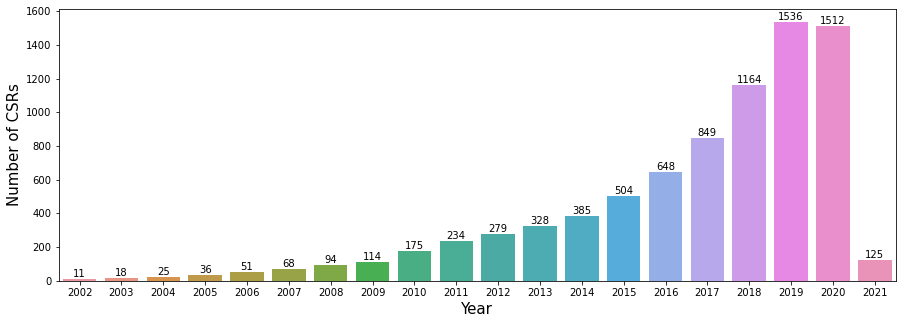

In [40]:
# Number of CSRs per year    
xs = []
ys = []
for year in np.sort(df_new_clean['Financial_Period_Absolute'].unique()):
    xs.append(year)
    ys.append(sum(df_new_clean['Financial_Period_Absolute'].astype(str) == str(year)))

plt.figure(figsize=(15,5))
ax = sns.barplot(x=xs, y=ys)
ax.bar_label(ax.containers[0])
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of CSRs", fontsize=15)
plt.show()

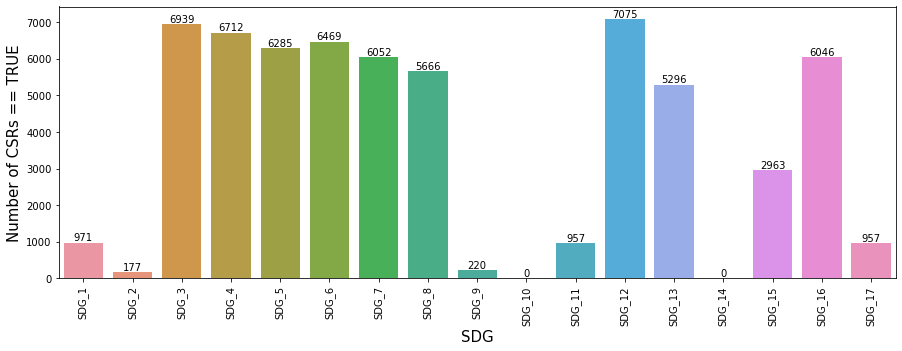

In [47]:
# Number of TRUE per SDG
xs = []
ys = []
for column in df_new_clean.columns[9:26]:
    xs.append(column)
    ys.append(sum(df_new_clean[column] == True))

plt.figure(figsize=(15,5))
ax = sns.barplot(x=xs, y=ys)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.xlabel("SDG", fontsize=15)
plt.ylabel("Number of CSRs == TRUE", fontsize=15)
plt.show()  